# select features using random forest

In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn

2025-01-11 09:41:07.953901: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 09:41:07.962547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 09:41:07.971418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 09:41:07.973965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 09:41:07.981205: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 2

# classifier

In [ ]:
from seq.classifier import Classifier
cl = Classifier()

## physcial chemical properties

In [21]:
infile = '/home/yuan/results/epitope/epi_physical_chemical.txt'
df1 = cl.get_df(infile)

input data: (3458238, 16)


In [22]:
#split data and train model
model1, X1_test, y1_test = cl.train_rf(df1)

X and y: (3458238, 15) float16 (3458238,) float16
labels: Counter({1.0: 1865242, 0.0: 1592996})
train data: (2420766, 15) (2420766,)
test_data:  (1037472, 15) (1037472,)


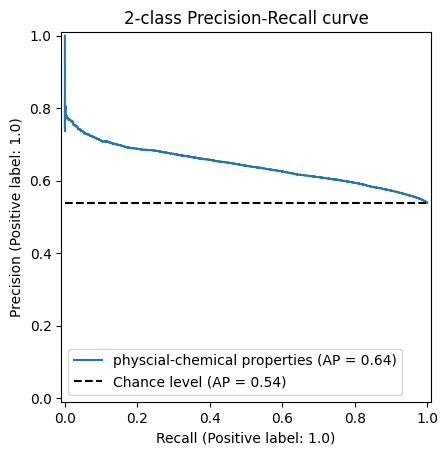

In [23]:
from sklearn.metrics import PrecisionRecallDisplay

# average precision
display = PrecisionRecallDisplay.from_estimator(
    model1, X1_test, y1_test, 
    name='physcial-chemical properties',
    plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

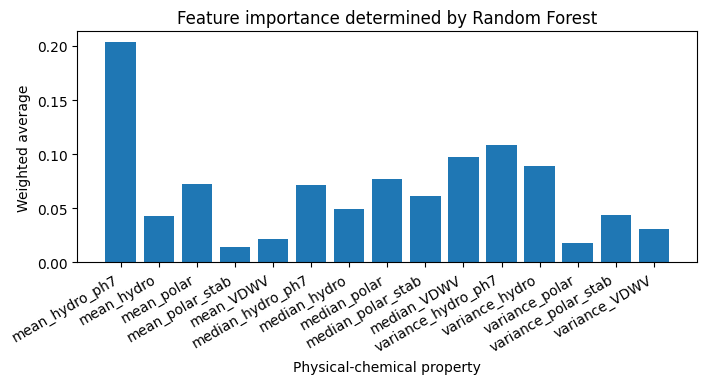

In [28]:
# feature importance
imp = pd.Series(model1.feature_importances_, index = list(df1)[:-1])

plt.figure(figsize=(8,3))
plt.bar(imp.index, imp)
plt.title('Feature importance determined by Random Forest')
plt.xlabel('Physical-chemical property')
plt.ylabel('Weighted average')
# ha: horizontal alignment
plt.xticks(rotation=30, ha='right')
plt.show()

## frequencies of amio acids

In [25]:
infile = '/home/yuan/results/epitope/epi_frequency_aa.txt'
df2 = cl.get_df(infile)

input data: (3458238, 537)


In [26]:
#split data and train model
model2, X2_test, y2_test = cl.train_rf(df2)

X and y: (3458238, 536) float16 (3458238,) float16
labels: Counter({1.0: 1865242, 0.0: 1592996})
train data: (2420766, 536) (2420766,)
test_data:  (1037472, 536) (1037472,)


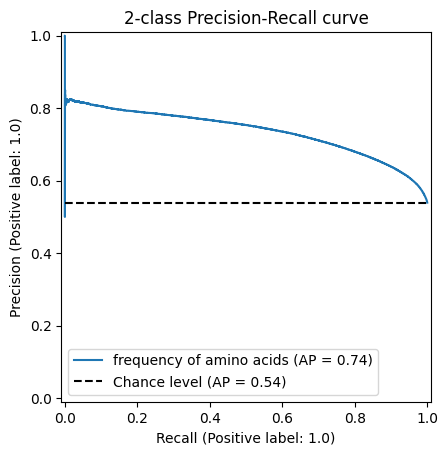

In [27]:
from sklearn.metrics import PrecisionRecallDisplay

# average precision
display = PrecisionRecallDisplay.from_estimator(
    model2, X2_test, y2_test, 
    name='frequency of amino acids',
    plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

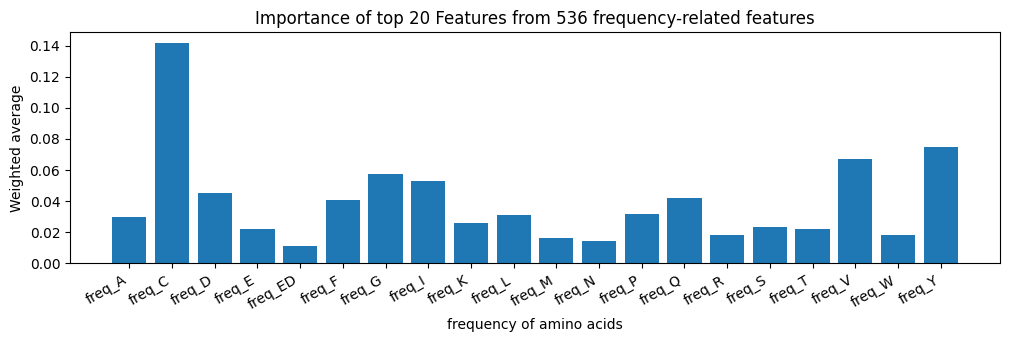

In [36]:
# feature importance
imp = pd.Series(model2.feature_importances_, index = list(df2)[:-1])
top_imp = imp[imp>0.01]

plt.figure(figsize=(12,3))
plt.bar(top_imp.index, top_imp)
plt.title(f'Importance of top {len(top_imp)} Features from {len(imp)} frequency-related features')
plt.xlabel('frequency of amino acids')
plt.ylabel('Weighted average')
# ha: horizontal alignment
plt.xticks(rotation=30, ha='right')
plt.show()

## all features

In [62]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

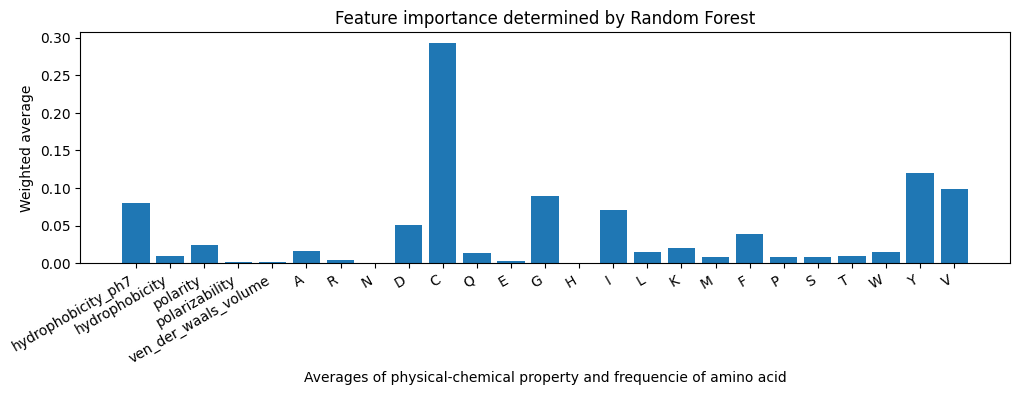

In [63]:
# feature importance
imp = pd.Series(model.feature_importances_, index = list(df)[:-1])

plt.figure(figsize=(12,3))
plt.bar(imp.index, imp)
plt.title('Feature importance determined by Random Forest')
plt.xlabel('Averages of physical-chemical property and frequencie of amino acid')
plt.ylabel('Weighted average')
# ha: horizontal alignment
plt.xticks(rotation=30, ha='right')
plt.show()

### testing

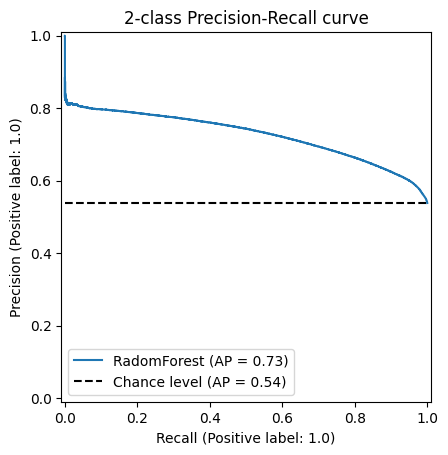

In [64]:
from sklearn.metrics import PrecisionRecallDisplay

# average precision
display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name='RadomForest', plot_chance_level=True)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [69]:
pred_test = model.predict(X_test)
pred_test[:10]

array([1., 1., 1., 0., 1., 1., 1., 0., 0., 1.], dtype=float16)

Text(0.5, 1.0, 'Prediction of non-epitopes 478874')

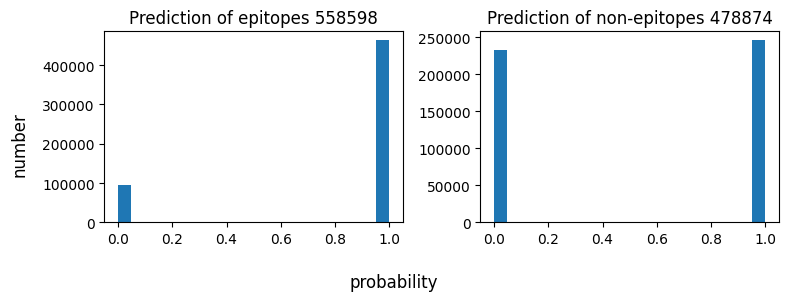

In [70]:
t = pred_test[y_test==1]
f = pred_test[y_test==0]
fig, ax = plt.subplots(1, 2, figsize=(8,3), layout='tight')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, label='True', bins=20)
ax[0].set_title(f'Prediction of epitopes {len(t)}')
ax[1].hist(f, label='False', bins=20)
ax[1].set_title(f'Prediction of non-epitopes {len(f)}')

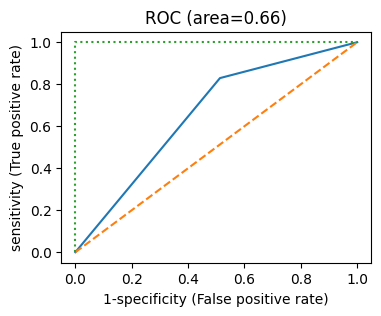

In [71]:
# ROC curve only for binary classfication
from sklearn.metrics import roc_curve, auc
# FPR, false positive rate, 1- specificity, typ I error
# TPR, true positive rate, sensitivity, power
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(fpr, tpr)
ax.set_xlabel('1-specificity (False positive rate)')
ax.set_ylabel('sensitivity (True positive rate)')
plt.title(f'ROC (area={roc_auc:.2f})')
ax.plot([0,1], [0,1], '--')
ax.plot([0,0,1], [0,1,1], ':')